# Goals

Here, we will cluster the interaction effects (β3) derived from our combinatorial screen. We will focus on conditions with high inter-replicate correlation. In addition to heirarchical clustering of all conditions, we will also use HDBSCAN to cluster combinations with similar interaction effects.

# Import

In [31]:
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd

# clustering packages
import hdbscan
import pymde
# set pymde seed to preserve reproducibility
pymde.seed(42)
from scipy.stats import zscore
from sklearn.manifold import SpectralEmbedding

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import re
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42
mpl.rcParams['text.usetex']  = False

import sys
sys.path.insert(0, '/data1/rudenska/EYW/git_projects/SIG13/functions')
import scanpy_custom as scc
import perturbseq as ps

In [ ]:
# import interaction coeff and classified lfc values
interCoeff = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/glmGamPoi/glmGamPoi_interaction/glmGamPoi_coefficients_0.2filter.csv")
interScored = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/glmGamPoi/interactions_scored_v3_glmGamPoi_0.05filter_sig.csv")
interLfcReplicates = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/glmGamPoi/glmGamPoi_interaction_independent_replicates/glmGamPoi_interaction_lfc_independent_replicates_0.2filter.csv")
interRepCor = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/replicate_corr/replicate_correlation_interactionLfc_0.2filter.csv")

/tmp/ipykernel_2455657/3886203206.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interScored = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/glmGamPoi/interactions_scored_v3_glmGamPoi_0.05filter_sig.csv")


# Helper Functions

In [13]:
def plot_heatmap(corr_matrix,
                      title='Heatmap', xlabel='Pearson\ncorr', cmap='magma',
                      method='ward', width=12, height=10,
                      xticklabels=True, yticklabels=True):
    """
    Plots a customizable heatmap with clustering and annotations.

    Parameters:
        corr_matrix (DataFrame): The data for the heatmap (correlation matrix).
        anno (DataFrame): DataFrame of annotations for rows.
        legend_handles (list): Handles for the legend.
        title (str): Title of the heatmap.
        cmap (str): Colormap for the heatmap.
        method (str): Clustering method (e.g., 'ward', 'average').
        vmax (float): Maximum value for the color scale.
    """
    g = sns.clustermap(
        corr_matrix, 
        annot=False, 
        cmap=cmap,
        method=method,
        center=0,
        dendrogram_ratio=(.1, 0),  # Adjusts the width of the dendrogram
        xticklabels=xticklabels,  # Ensures all x-axis labels are shown
        yticklabels=yticklabels,  # Ensures all y-axis labels are shown
        cbar_kws={
            'orientation': 'vertical',  # Vertical colorbar
            'shrink': 0.5,  # Shrink the colorbar size
        },
        figsize=(width, height)
    )

    # Adjust the colorbar and tick labels
    g.cax.set_position([1.03, 0.5, .03, .2])  # [x, y, width, height] for the colorbar position
    g.cax.set_xlabel(xlabel, fontsize=10)  # Set horizontal label
    g.cax.xaxis.set_label_position('top')  # Position the label below the colorbar
    
    # Customize labels and title
    g.ax_heatmap.set_xlabel("")
    g.ax_heatmap.set_ylabel("")
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
    g.ax_heatmap.set_title(title, fontsize=20)

    plt.show()

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_heatmap_anno(corr_matrix,
                      row_colors=None,
                      title='Heatmap',
                      xlabel='Pearson\ncorr',
                      cmap='magma',
                      method='ward',
                      vmax=1,
                      vmin=-1,
                      width=12,
                      height=10,
                      xticklabels=True,
                      yticklabels=True):
    """
    Plots a clustered heatmap with automatic legends for row_colors.
    Assumes row_colors are categorical labels (not color codes).
    """
    # ——— Prepare row_colors as Series or DataFrame ———
    if isinstance(row_colors, (list, tuple, np.ndarray)):
        row_colors = pd.Series(row_colors, index=corr_matrix.index)

    # This dict will hold { track_name: {category: color} }
    mapping_dict = {}

    # ——— Single‐track annotation ———
    if isinstance(row_colors, pd.Series):
        rc = row_colors.reindex(corr_matrix.index).astype(str)
        cats = rc.dropna().unique()
        palette = sns.color_palette("tab20", n_colors=len(cats))
        lut = dict(zip(cats, palette))
        row_colors = rc.map(lut)
        # Use the Series name or generic
        track_name = rc.name if rc.name is not None else 'Annotation'
        mapping_dict[track_name] = lut

    # ——— Multi‐track annotation ———
    elif isinstance(row_colors, pd.DataFrame):
        rc_df = row_colors.reindex(index=corr_matrix.index).astype(str).copy()
        for col in rc_df.columns:
            vals = rc_df[col]
            cats = vals.dropna().unique()
            palette = sns.color_palette("tab20", n_colors=len(cats))
            lut = dict(zip(cats, palette))
            rc_df[col] = vals.map(lut)
            mapping_dict[col] = lut
        row_colors = rc_df

    # ——— Draw the clustermap ———
    g = sns.clustermap(
        corr_matrix,
        row_colors=row_colors,
        annot=False,
        cmap=cmap,
        method=method,
        vmax=vmax,
        vmin=vmin,
        dendrogram_ratio=(.1, 0),
        xticklabels=xticklabels,
        yticklabels=yticklabels,
        cbar_kws={'orientation': 'vertical', 'shrink': 0.5},
        figsize=(width, height),
    )

    # ——— Tidy up colorbar ———
    g.cax.set_position([1.01, 0.1, .03, .2])
    g.cax.set_xlabel(xlabel, fontsize=10)
    g.cax.xaxis.set_label_position('top')

    # ——— Clean heatmap axes & title ———
    g.ax_heatmap.set_xlabel("")
    g.ax_heatmap.set_ylabel("")
    g.ax_heatmap.set_xticklabels(
        g.ax_heatmap.get_xticklabels(), fontsize=9
    )
    g.ax_heatmap.set_yticklabels(
        g.ax_heatmap.get_yticklabels(), fontsize=9
    )
    g.ax_heatmap.set_title(title, fontsize=20)

    # ——— Add one legend per annotation track ———
    for i, (track, lut) in enumerate(mapping_dict.items()):
        patches = [
            mpatches.Patch(color=col, label=cat)
            for cat, col in lut.items()
        ]
        # stagger legends vertically
        y0 = 1.0 - i*0.15
        g.ax_heatmap.legend(
            handles=patches,
            title=track,
            bbox_to_anchor=(1.1, y0),
            bbox_transform=g.ax_heatmap.transAxes,
            loc='upper left'
        )

    plt.show()
    return g

# Select consistent ligands and genes

Here, we filter for ligands based on previously calculated inter-replicate pearson correlation. We also filter for the top 2000 most variable genes.

In [ ]:
# select ligands based on pearson correlation cutoff and having at least one shared deg between replicates
consistent_ligands = interRepCor.loc[((interRepCor['pearson_corr'] > 0.25) & (interRepCor['num_shared_genes'] > 1)), 
                                     'interaction'].unique()

In [ ]:
# select top n genes based on variance in interaction lfc
genes_selected = (
    interScored
    .loc[interScored['interaction'].isin(consistent_ligands)]
    .groupby('name')['lfc_interaction']
    .var()
    .nlargest(2000)
    .index.tolist()
)

# Plot Full Correlation Heatmap

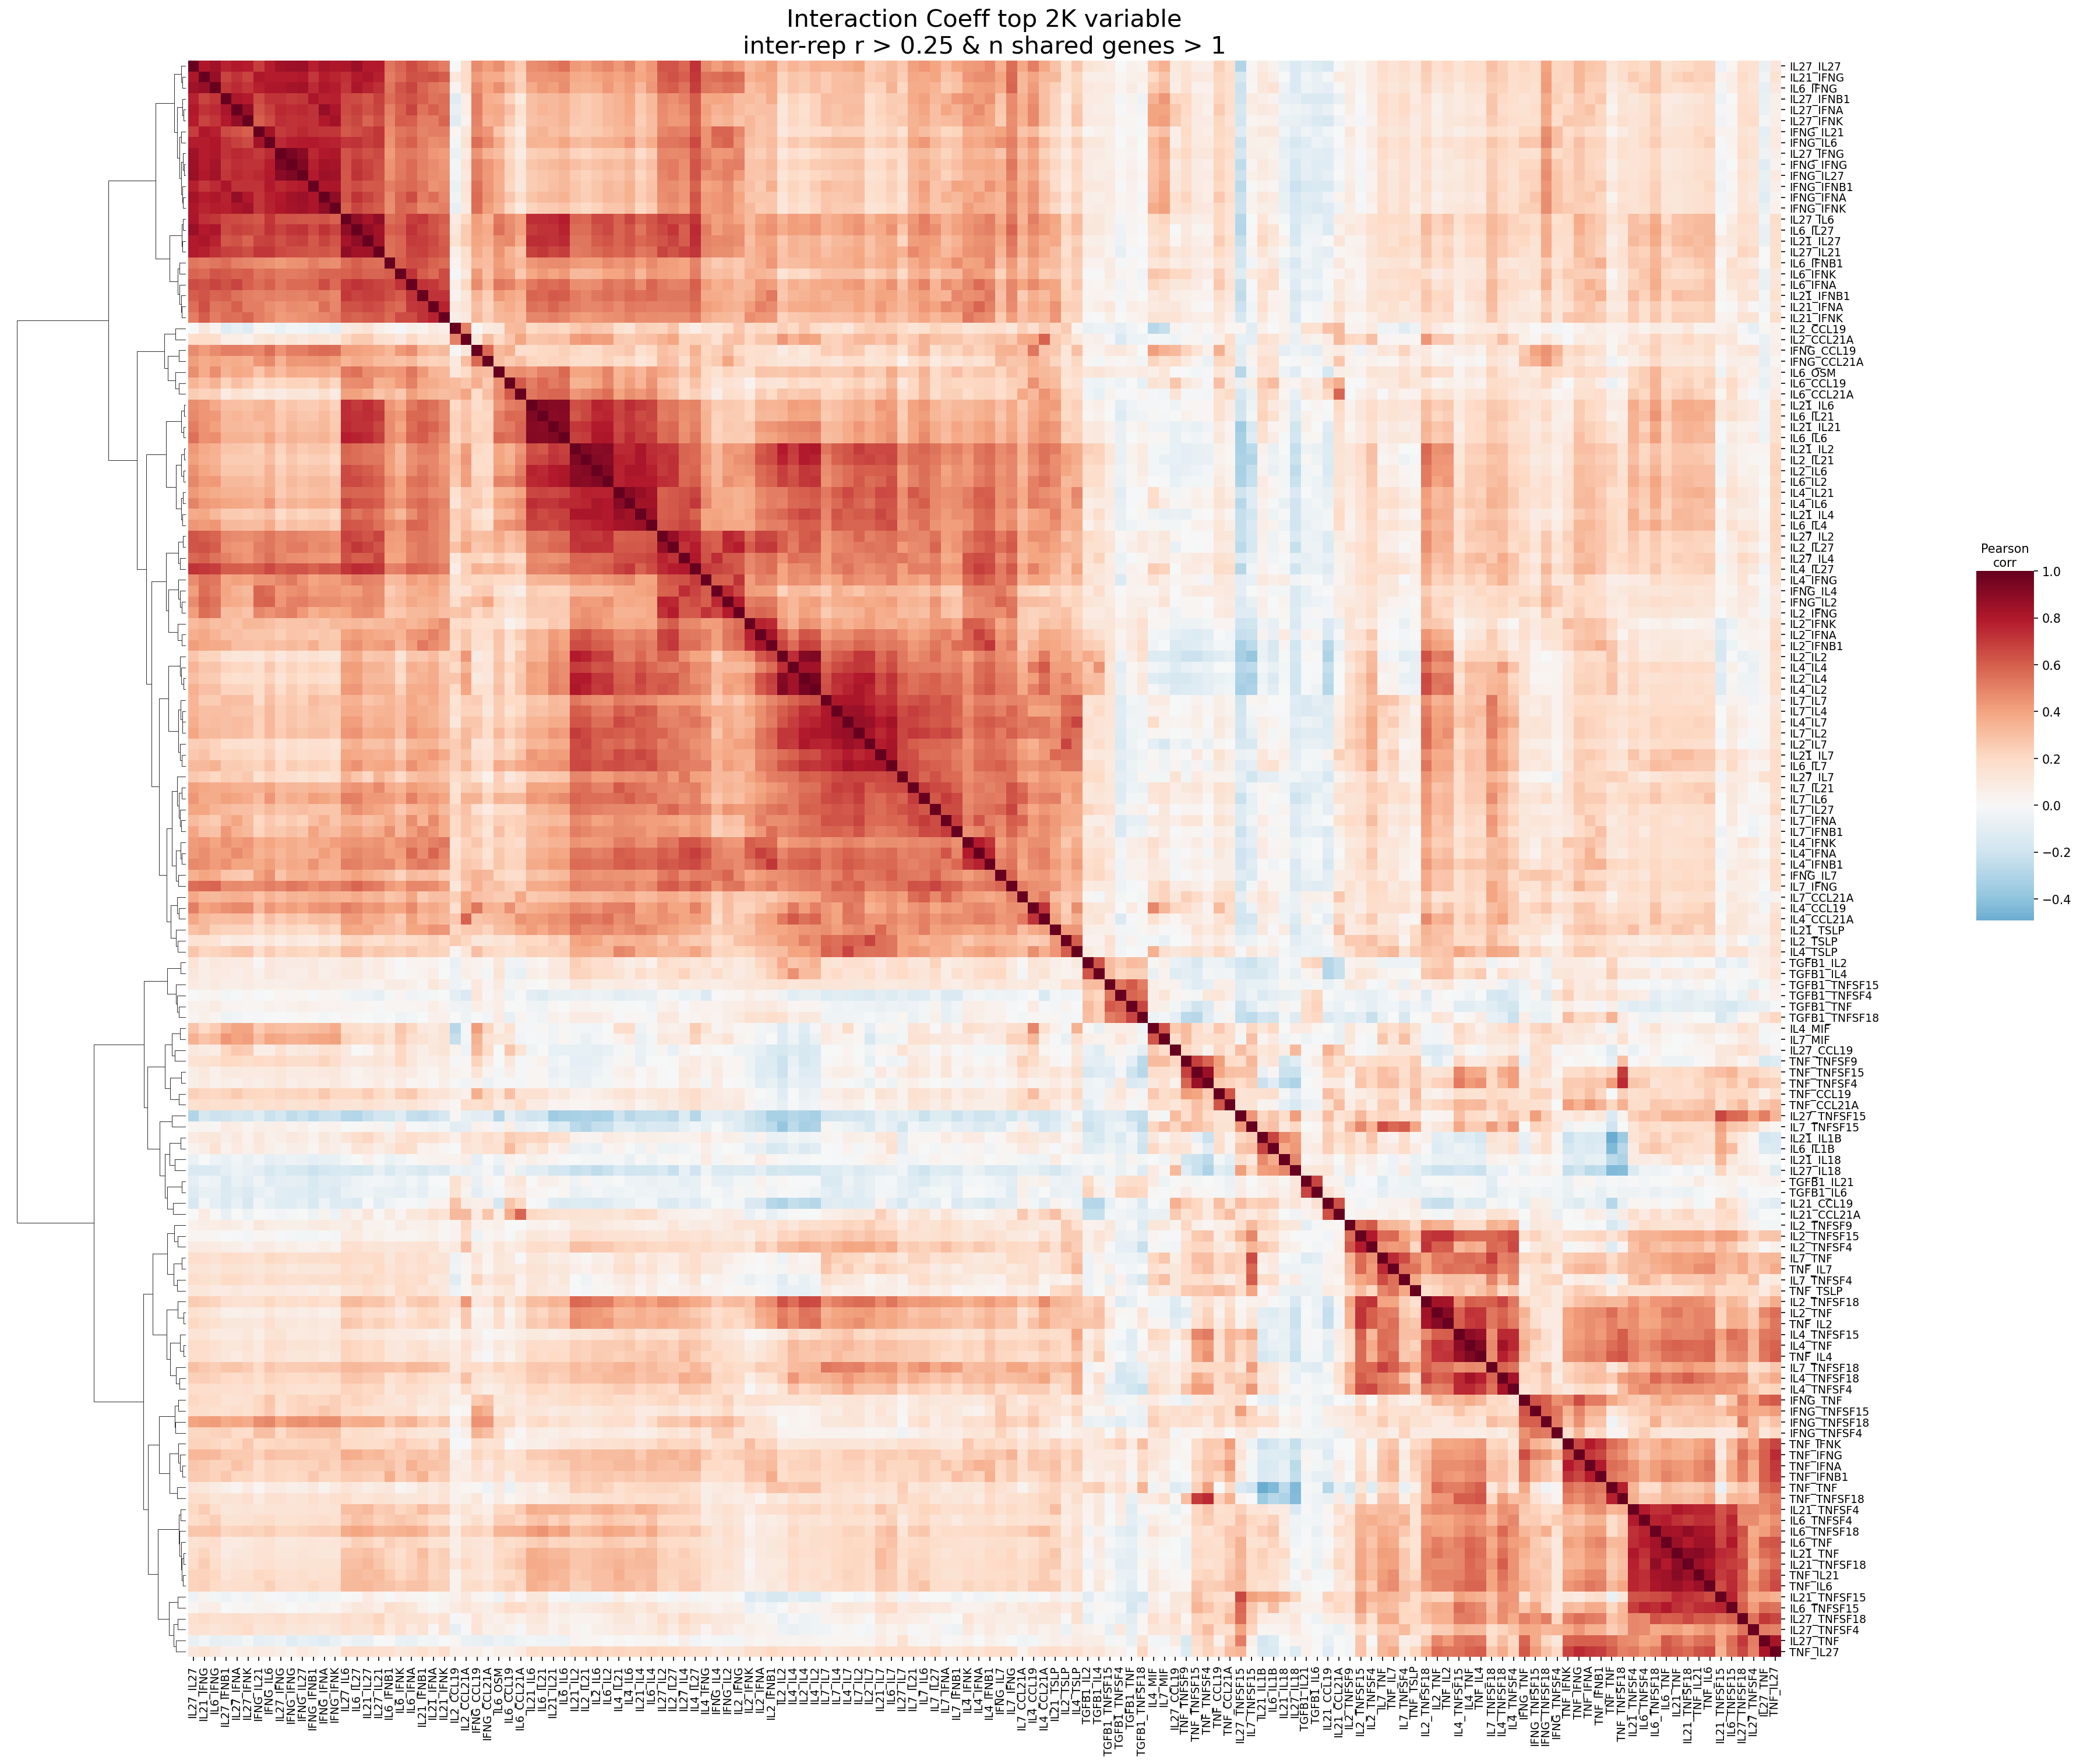

In [32]:
# Build the correlation matrix
wide_mat = (
    interCoeff
    .loc[
        interCoeff['interaction'].isin(consistent_ligands) &
        interCoeff['genes'].isin(genes_selected)
    ]
    .pivot_table(
        index='genes',
        columns='interaction',
        values='ligand1:ligand2',
        fill_value=0
    )
)
corr_mat = wide_mat.corr(method='pearson')

plot_heatmap(
    corr_matrix=corr_mat,
    title='Interaction Coeff top 2K variable\ninter-rep r > 0.25 & n shared genes > 1',
    cmap='RdBu_r',
    method='ward',
    width=22,
    height=20
)


# HDBSCAN clustering

Here, I will perform HDBSCAN clustering with different levels of strictness (min_samples) and a min_cluster_size of 2. I chose 2 to maximize the number of unique clusters that can be pulled out and because from looking at the clustermap, it is clear that there are distinct groups composed of two different ligand combinations.

In [34]:
# Build the correlation matrix
wide_mat = (
    interCoeff
    .loc[
        interCoeff['interaction'].isin(consistent_ligands) &
        interCoeff['genes'].isin(genes_selected)
    ]
    .pivot_table(
        index='interaction',
        columns='genes',
        values='ligand1:ligand2',
        fill_value=0
    )
)

# Initialize and run HDBSCAN
clusterer_1 = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    metric='correlation'
)
clusterer_2 = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=2,
    metric='correlation'
)

# Fit and get cluster labels
clusters_1 = clusterer_1.fit_predict(wide_mat.values)
clusters_2 = clusterer_2.fit_predict(wide_mat.values)

# move clusters into dataframe
hdbscan_clusters = pd.DataFrame(
    {'hdbscan_cluster_1': clusters_1,
     'hdbscan_cluster_2': clusters_2},
    index=wide_mat.index
)
hdbscan_clusters.to_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/clustering/hdbscan_interaction_coeff_clusters.csv")


# Plot Correlation Heatmaps with HDBSCAN Clusters

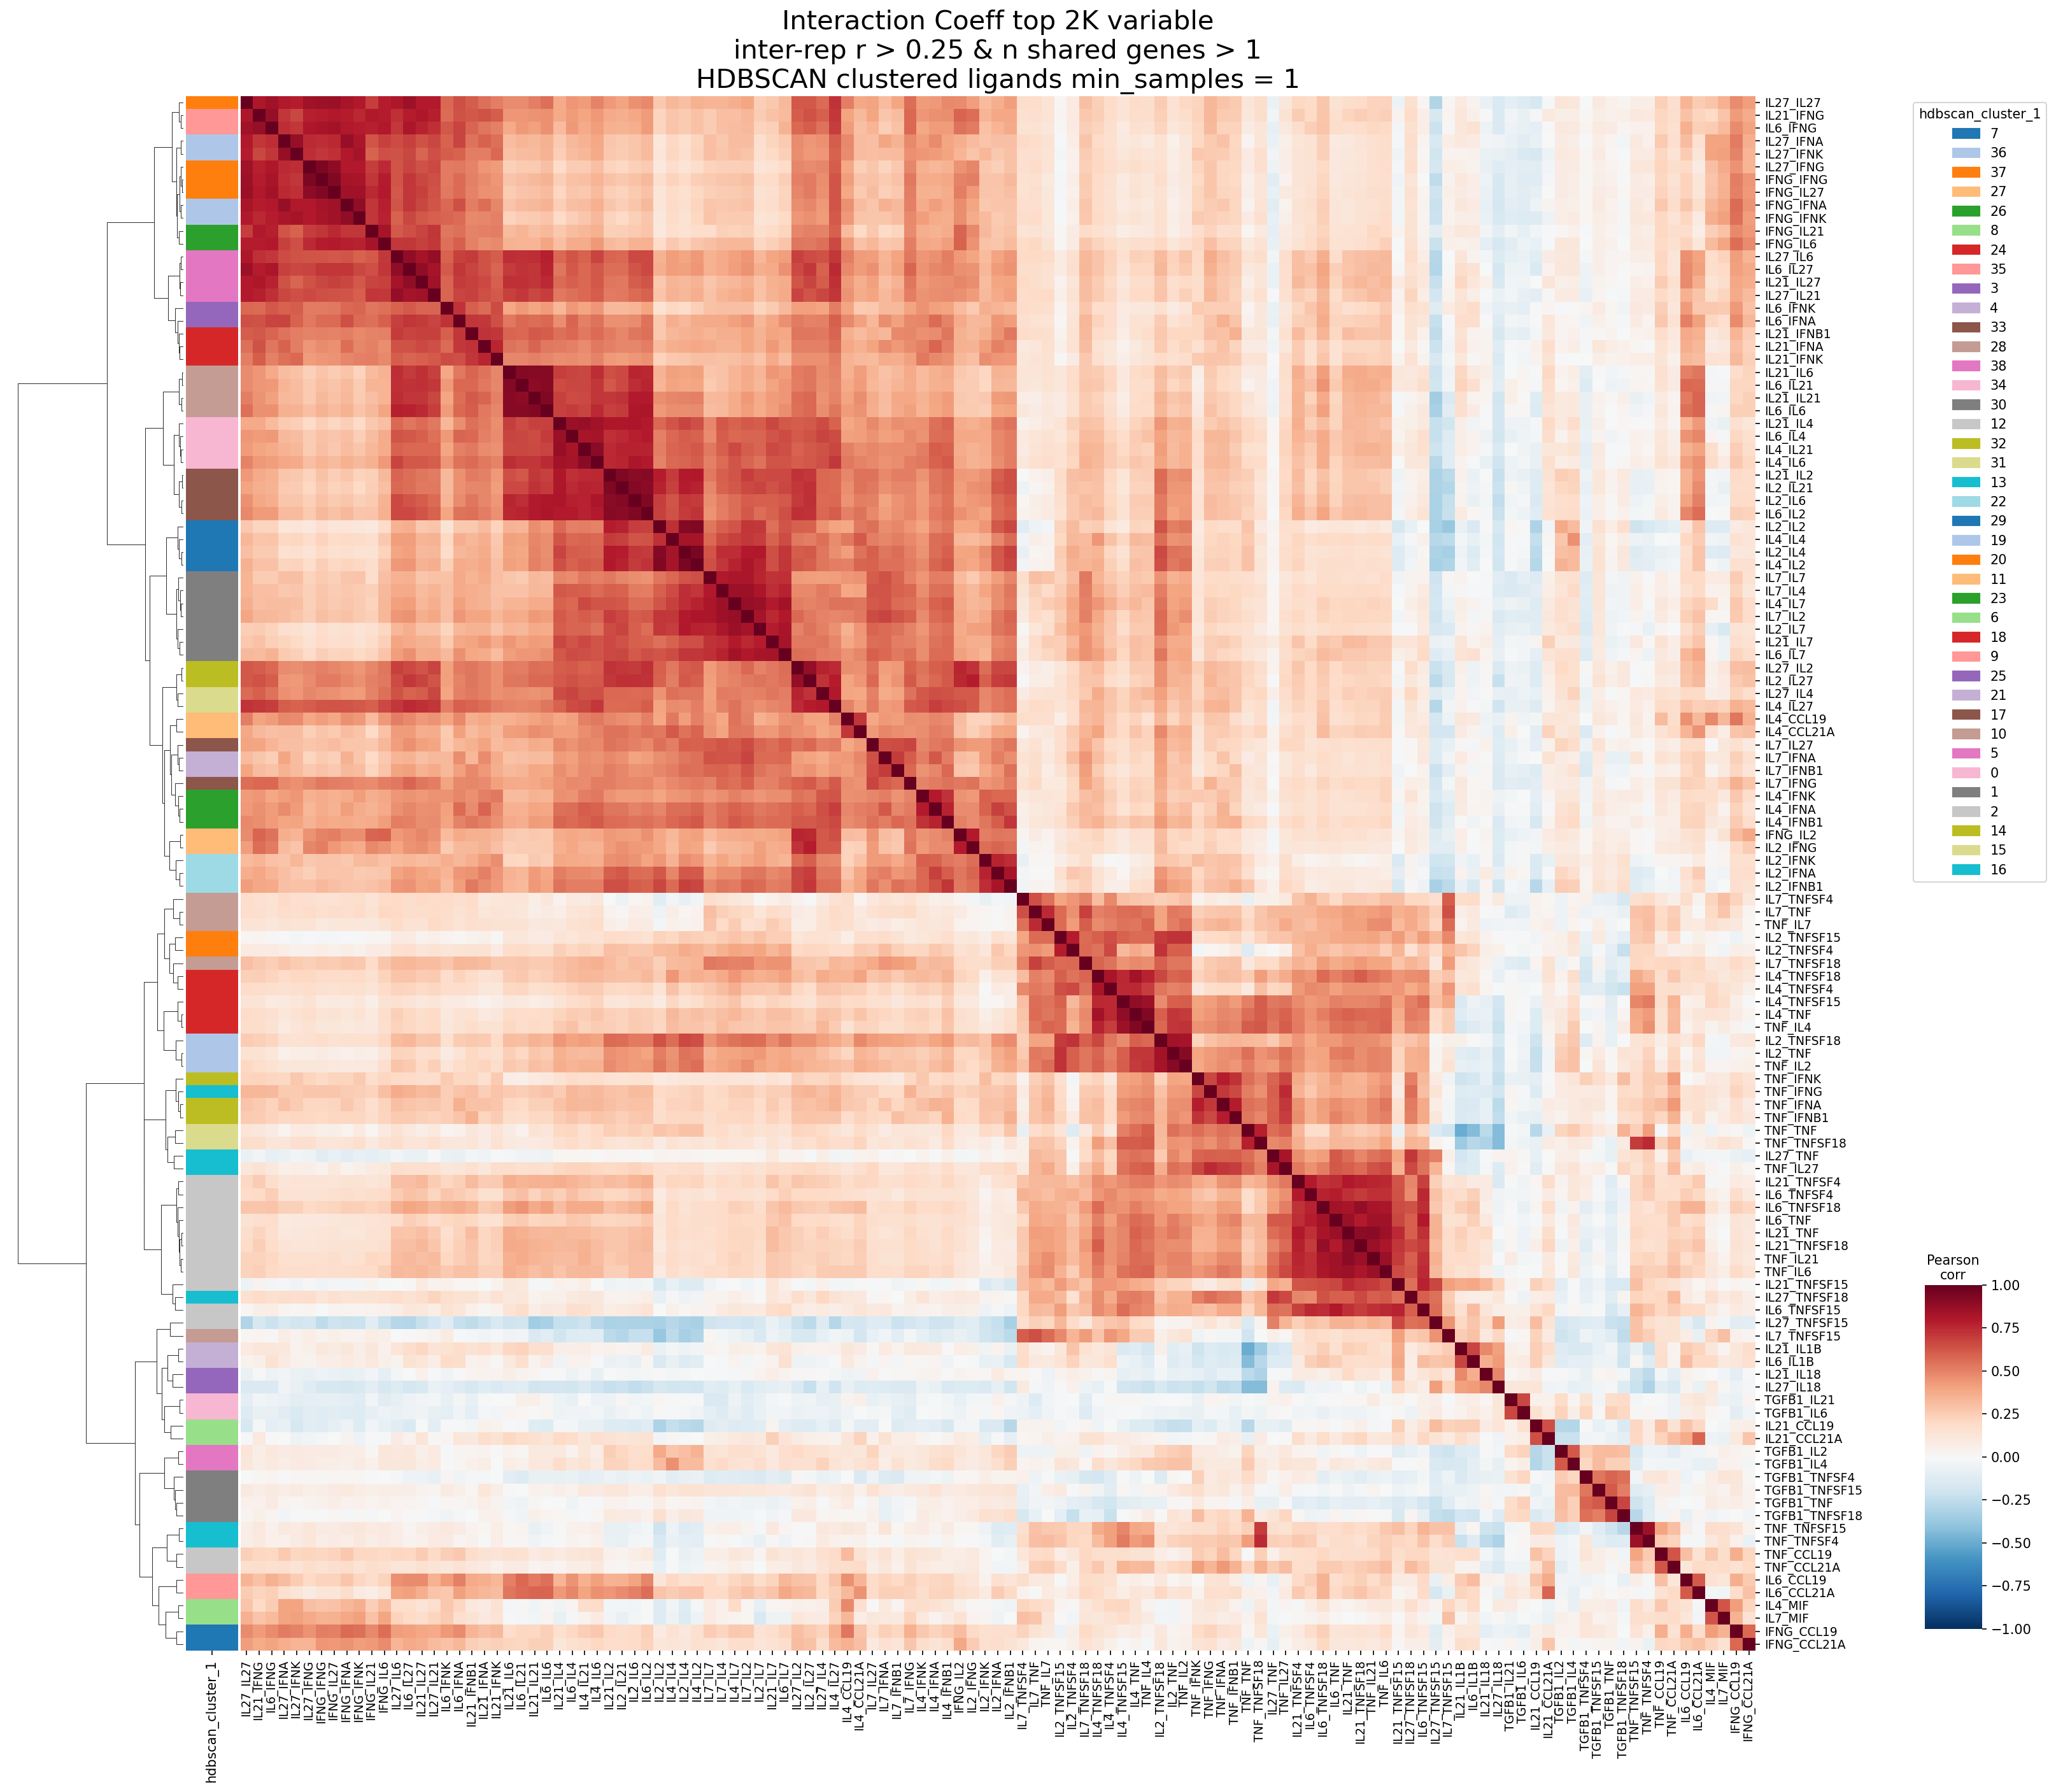

In [36]:
clusters_plot = hdbscan_clusters.query('hdbscan_cluster_1 != -1')
wide_mat_clustered = wide_mat.loc[clusters_plot.index, :]
corr_mat = wide_mat_clustered.T.corr(method='pearson')

plt_obj = plot_heatmap_anno(
    corr_matrix=corr_mat,
    row_colors=clusters_plot.hdbscan_cluster_1,
    title='Interaction Coeff top 2K variable\ninter-rep r > 0.25 & n shared genes > 1\nHDBSCAN clustered ligands min_samples = 1',
    cmap='RdBu_r',
    method='ward',
    width=20,
    height=18
)

plt_obj.savefig("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/plots/interaction_coeff_heatmap_hdbscan1.pdf", bbox_inches="tight")

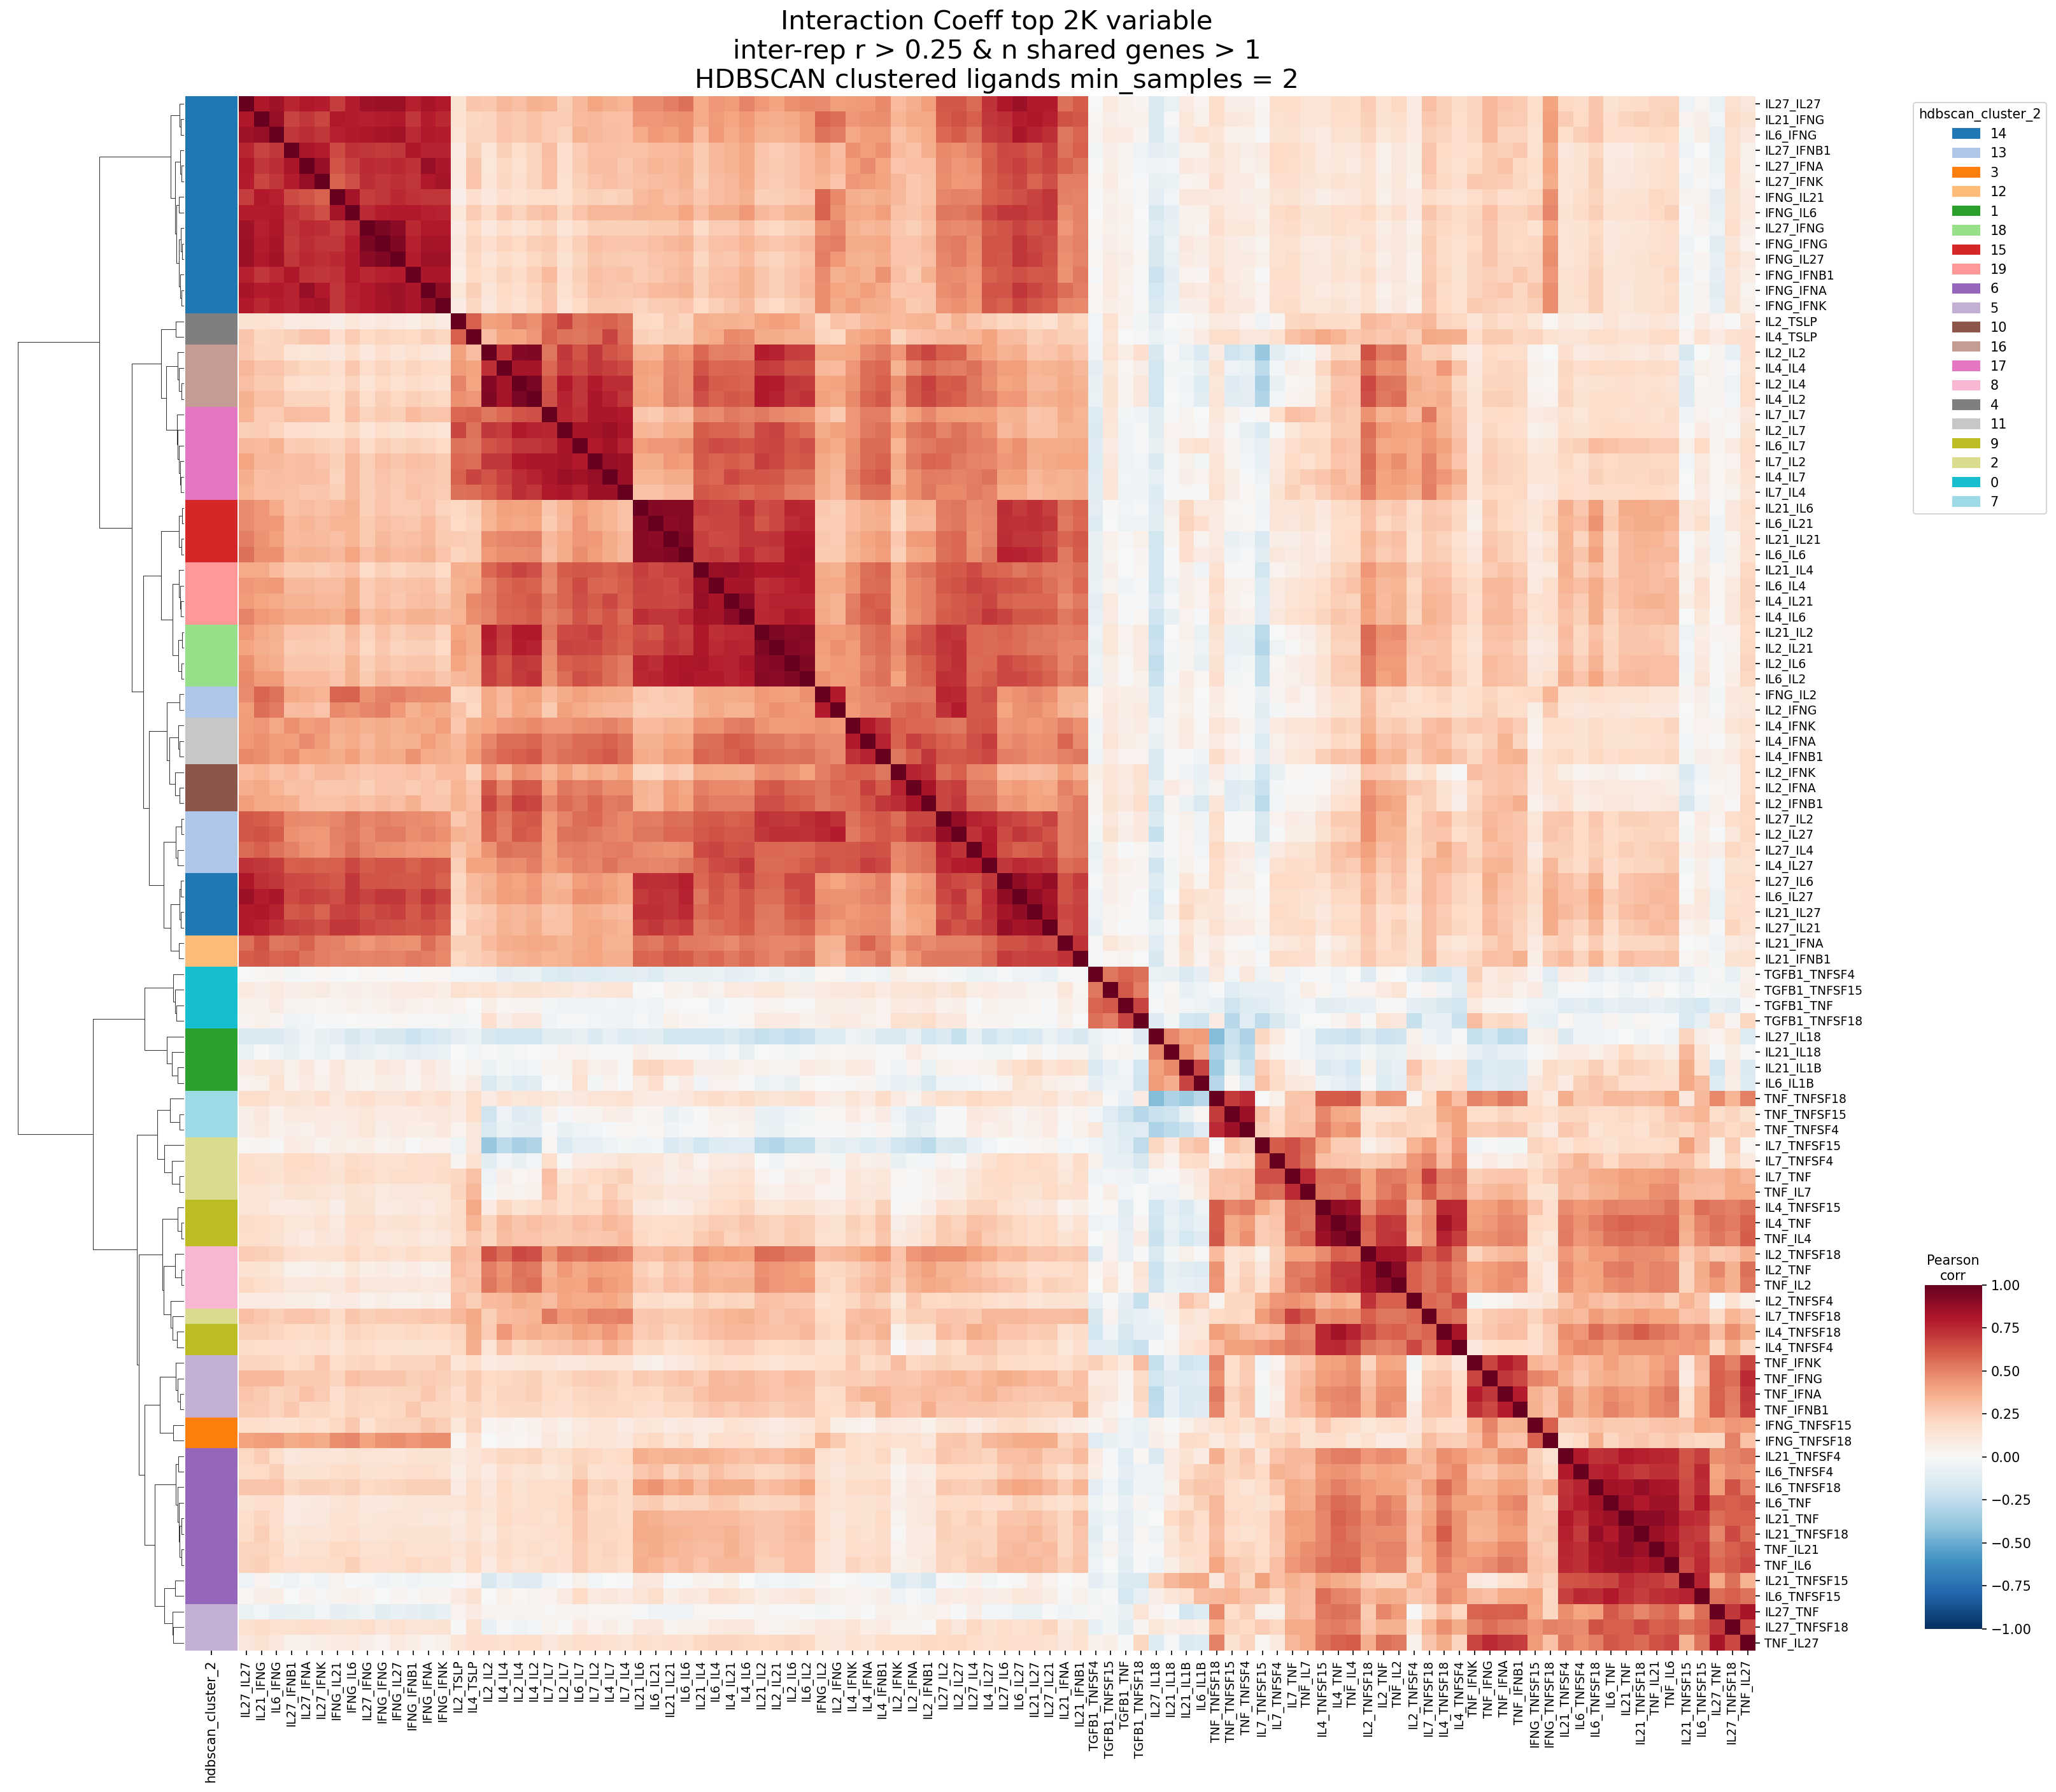

In [22]:
clusters_plot = hdbscan_clusters.query('hdbscan_cluster_2 != -1')
wide_mat_clustered = wide_mat.loc[clusters_plot.index, :]
corr_mat = wide_mat_clustered.T.corr(method='pearson')
plot_heatmap_anno(
    corr_matrix=corr_mat,
    row_colors=clusters_plot.hdbscan_cluster_2,
    title='Interaction Coeff top 2K variable\ninter-rep r > 0.25 & n shared genes > 1\nHDBSCAN clustered ligands min_samples = 2',
    cmap='RdBu_r',
    method='ward',
    width=20,
    height=18
)